In [72]:
import numpy as np
import pandas as pd
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#ignore warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [73]:
student = pd.read_csv("student-por.csv" ,sep=';')
student.columns = ['school','sex','age','address','family_size','parents_status','mother_education','father_education',
           'mother_job','father_job','reason','guardian','commute_time','study_time','failures','school_support',
          'family_support','paid_classes','activities','nursery','desire_higher_edu','internet','romantic','family_quality',
          'free_time','go_out','weekday_alcohol_usage','weekend_alcohol_usage','health','absences','period1_score','period2_score','final_score']
# convert final_score to categorical variable # Good:15~20 Fair:10~14 Poor:0~9
student['final_grade'] = 'na'
student.loc[(student.final_score >= 15) & (student.final_score <= 20), 'final_grade'] = 'good' 
student.loc[(student.final_score >= 10) & (student.final_score <= 14), 'final_grade'] = 'fair' 
student.loc[(student.final_score >= 0) & (student.final_score <= 9), 'final_grade'] = 'poor'

# create dataframe dfd for classification
data = student.copy()
data = data.drop([ 'final_score'], axis=1)
# label encode final_grade
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data.final_grade = le.fit_transform(data.final_grade)

# dataset train_test_split
X = data.drop('final_grade',axis=1)
y = data.final_grade

def normalization(X):
    mean = np.mean(X)
    std = np.std(X)
    X_t = (X - mean)/std
    return X_t

#Normalization
X_t = normalization(X)
print("X_t:", X_t.shape)
X = X_t
X_norm=X.dropna(axis=1,how='all')

X_t: (649, 32)


In [74]:
Clus_dataset = StandardScaler().fit_transform(X_norm)

## Find the best number of clusters

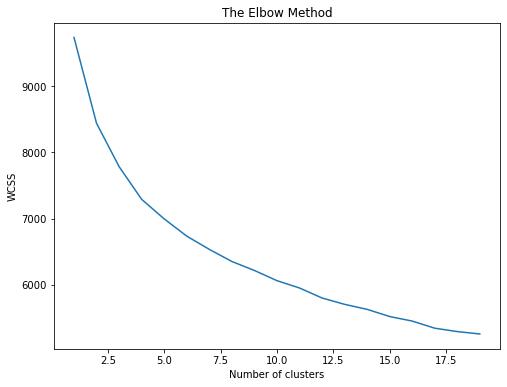

In [4]:
# Basically, number of clusters = the x-axis value of the point that is the corner of the "elbow"(the plot looks often looks like an elbow)
wcss = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300, n_init=11, random_state=0)
    kmeans.fit(X_norm)
    wcss.append(kmeans.inertia_)
f3, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1,20),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [5]:
# build the model with the output from elbow method which is 2
clusterNum = 25
k_means =KMeans(init='k-means++', n_clusters=clusterNum, n_init=12)
k_means.fit(X_norm)
labels = k_means.labels_

In [76]:
from sklearn.metrics.cluster import rand_score
rand_score(y, labels)

0.5351014856664574

In [7]:
import matplotlib.cm as cm

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import silhouette_samples, silhouette_score

NMI score: 0.235514
For n_clusters = 2 The average silhouette_score is : 0.14497248334140697


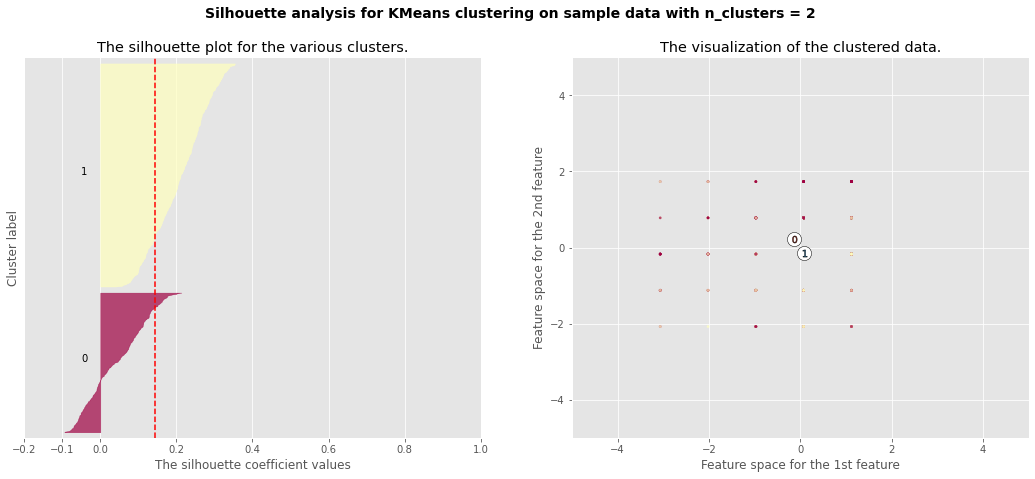

NMI score: 0.171230
For n_clusters = 3 The average silhouette_score is : 0.09596404973257139


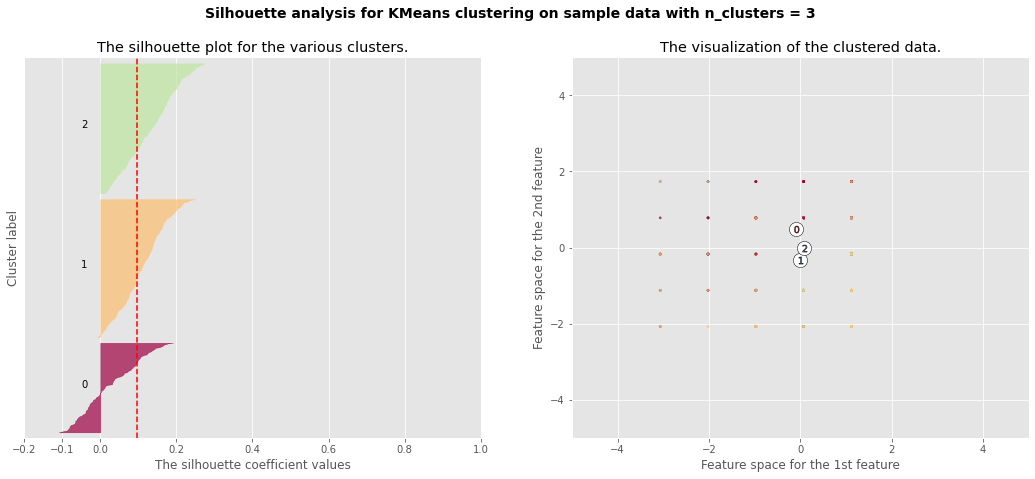

NMI score: 0.152847
For n_clusters = 4 The average silhouette_score is : 0.09989817222483013


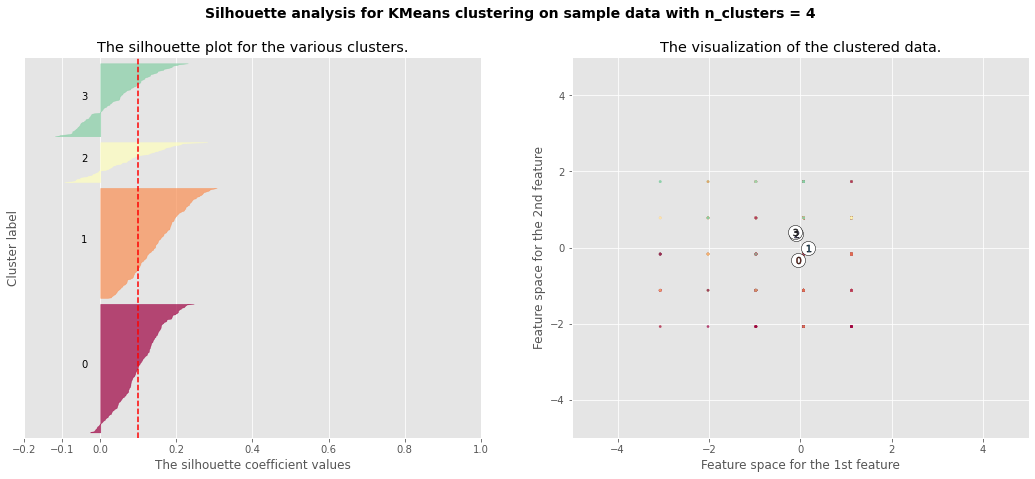

NMI score: 0.172274
For n_clusters = 5 The average silhouette_score is : 0.08663264470923336


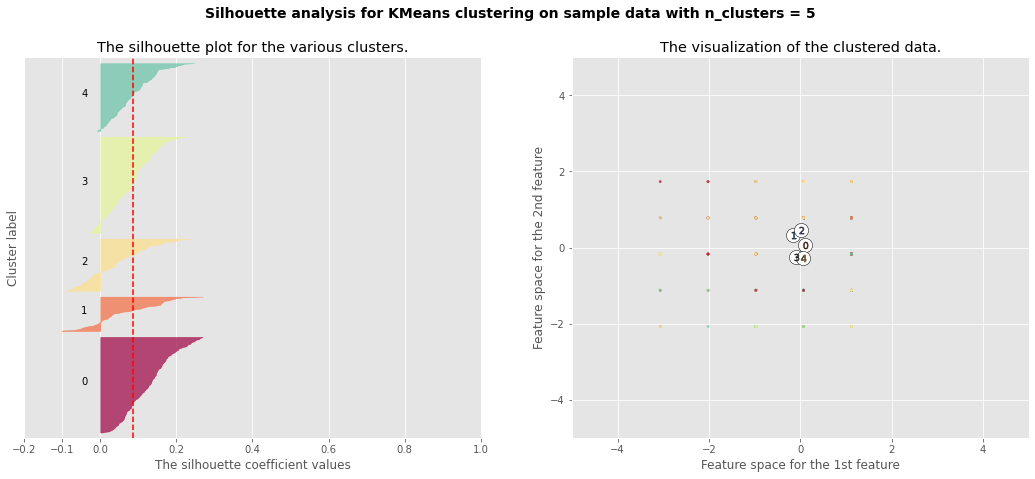

NMI score: 0.155989
For n_clusters = 6 The average silhouette_score is : 0.08386153876003741


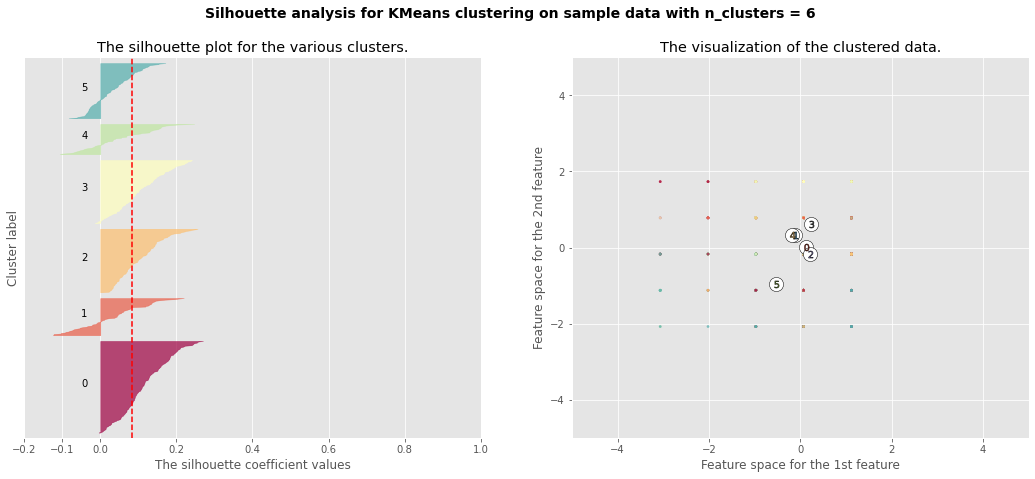

NMI score: 0.166258
For n_clusters = 7 The average silhouette_score is : 0.07562615141389471


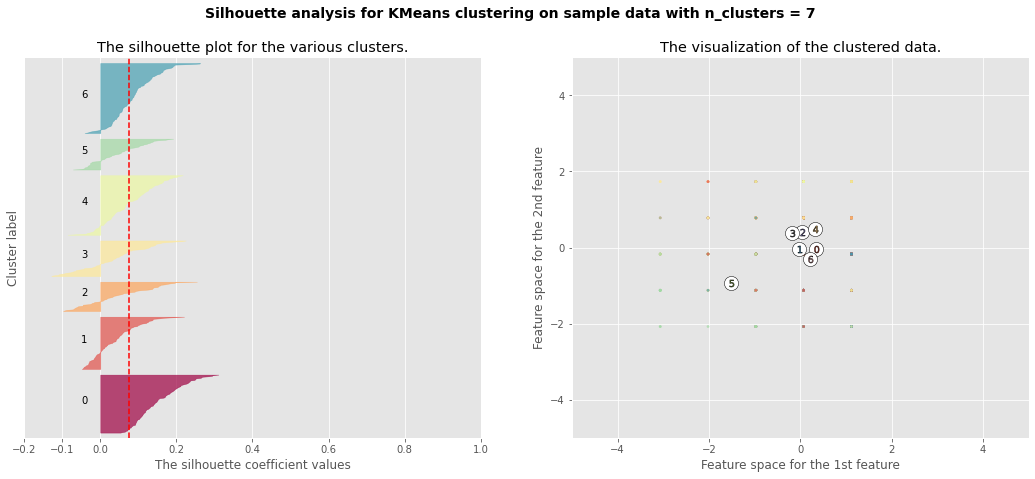

In [19]:
#K means clustering

range_n_clusters = [2,3,4,5,6,7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_norm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X_norm)
    cluster_labels = clusterer.labels_
    print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_norm, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter( X_norm.iloc[:, 4], X_norm.iloc[:, 6], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 4], centers[:, 6], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter( c[4], c[6], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    ax2.axis([-5,5,-5,5])

    plt.show()

## GMM

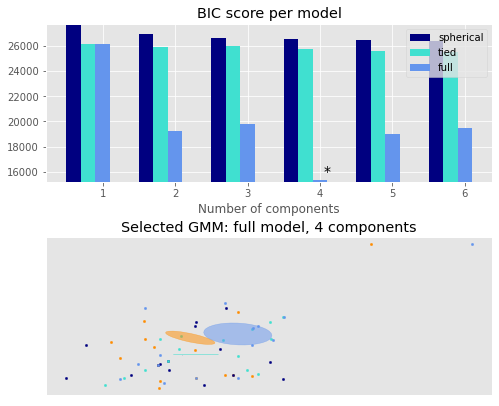

In [70]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0.0, -0.1], [1.7, 0.4]])
X = X_norm

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_norm)
        bic.append(gmm.bic(X_norm))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)

# a = clf.covariances_.copy()
# final = []
# for i in range(len(a)):
#     final.append(np.diag(a[i,:]))
# ff = np.concatenate(final).reshape((4,15,15))

Y_ = clf.predict(X_norm)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_norm[Y_ == i].iloc[5], X_norm[Y_ == i].iloc[9], 5, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

In [78]:
rand_score(y, best_gmm.predict(X_norm))

0.531025889782952

NMI score: 0.122250


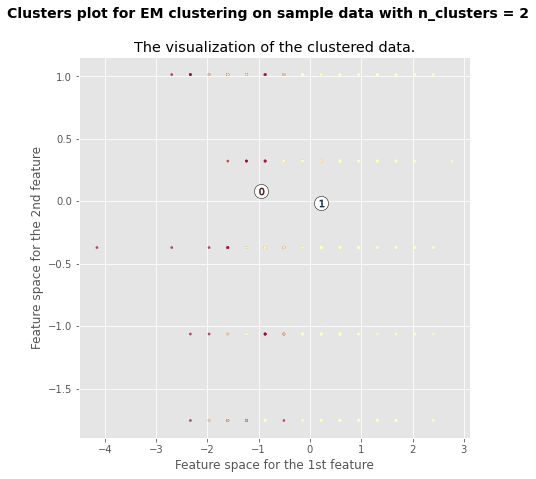

NMI score: 0.113938


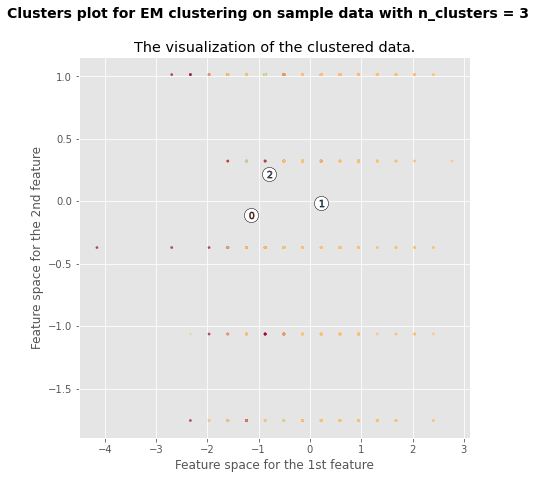

NMI score: 0.094871


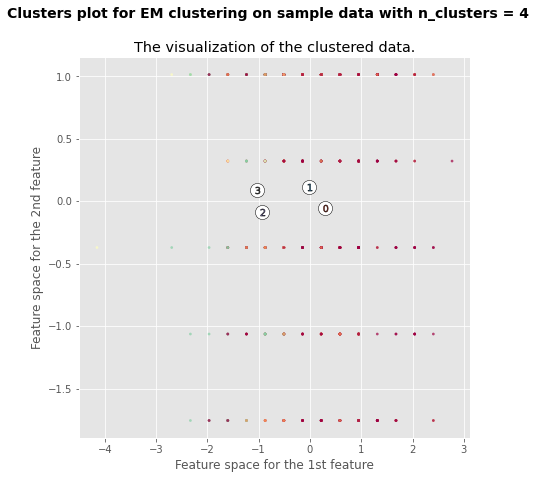

NMI score: 0.108081


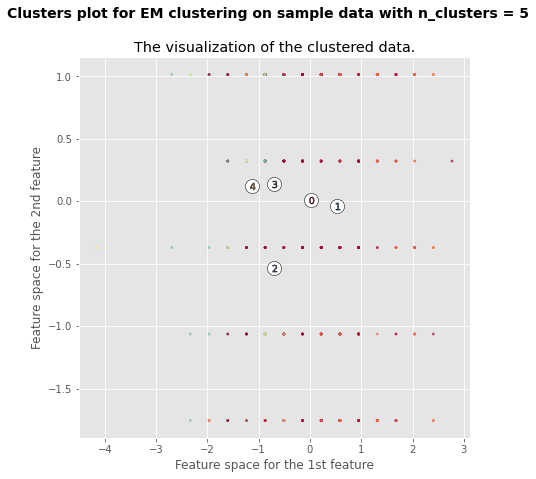

NMI score: 0.091739


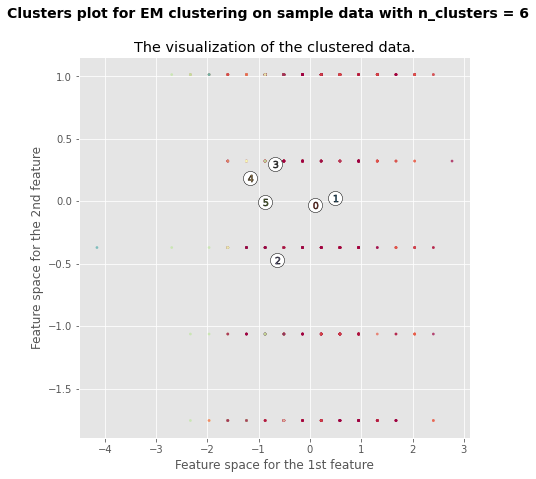

NMI score: 0.103520


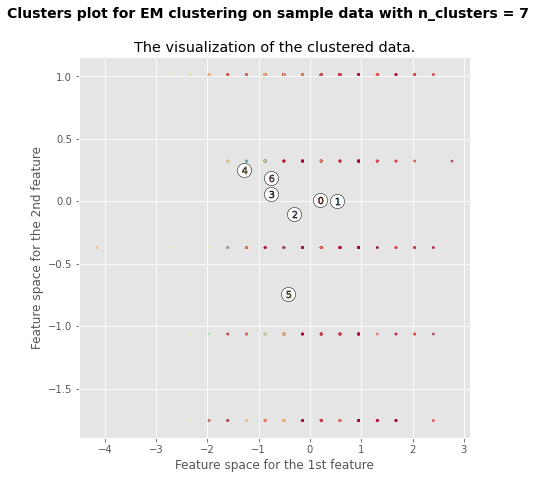

In [14]:
#################################################
#Expectation Maximization clustering

for n_clusters in range_n_clusters:
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    ax = fig.add_subplot(111)
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_norm)
    cluster_labels = clusterer.predict(X_norm)
    print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

    # 2nd Plot showing the actual clusters formed
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    plt.scatter( X_norm.iloc[:, 10], X_norm.iloc[:, 8], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.means_

    # Draw white circles at cluster centers
    plt.scatter(centers[:, 10], centers[:, 8], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax.scatter( c[10], c[8], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax.set_title("The visualization of the clustered data.")
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Clusters plot for EM clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()